# TODO - ROC curves, minimal equal error rate plot, evaulation of ROC over time (overlay with average?)
# Implement gridsearch to optimise the model? (Use validation set of data)
Working on this problem: https://www.cs.cmu.edu/~keystroke/.
Supporting paper: http://www.cs.cmu.edu/~keystroke/KillourhyMaxion09.pdf

Data comes from 51 subjects typing ".tie5Roanl" 400 times across multiple sessions.

Our goal is to develop a model which has a minimal equal error rate. 

(Diagram of minimal equal error rate https://api.intechopen.com/media/chapter/66135/media/F2.png).

Questions that immediately need answering:
- What type of problem is this (classification or regression)?
- Has anyone attempted this problem before?
    - If so, how did they approach it? 
        - Which detectors / feature sets / models did they use?
        - What was successful about their approach? 
        - What were their limitations?
- What do the features in the dataset represent?
- Which do we prioritise - false poitives or false negatives (aka in this context: false-alarm rates and miss rates).
    - From the literature (and common sense to be honest), we should prioritise lowering miss rates (it's better to lock out a user, than have a threat access the system).

These were largely answered through reading the aforementioned paper, and doing some background reading and research.

The aforementioned paper also detailed a method by which different detectors could be compared on the same dataset. So to evaluate how our 'new' model performs against its competitors, it makes sense to first implement a pre-existing model, then our new model, and compare performance under the same conditions.

Note: The paper implemented the techniques using R (which I've not used before). Implementation in Python _should_ be the same, but there may be some underlying differences in R/Python's mathematics libraries

# Imports and file processing
Let's import some relevant modules and see what the file's contents are.

In [1]:
# First, imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
# for Manhattan detector, need cityblock distance
from scipy.spatial.distance import cityblock
from itertools import zip_longest

In [2]:
# Read in csv file and check what's inside
df = pd.read_csv('DSL-StrongPasswordData.csv')
df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


In [3]:
subjects = df["subject"].unique()
print(subjects) 
# Confirmation there are 51 unique subjects

['s002' 's003' 's004' 's005' 's007' 's008' 's010' 's011' 's012' 's013'
 's015' 's016' 's017' 's018' 's019' 's020' 's021' 's022' 's024' 's025'
 's026' 's027' 's028' 's029' 's030' 's031' 's032' 's033' 's034' 's035'
 's036' 's037' 's038' 's039' 's040' 's041' 's042' 's043' 's044' 's046'
 's047' 's048' 's049' 's050' 's051' 's052' 's053' 's054' 's055' 's056'
 's057']


# Model development

It is evident this is a classification problem, rather than a regression problem. 

Firstly, let's approach this using standard anomaly detection practices - we will train a model to recognise a certain user's typing pattern, and then test it against the remaining (i.e. imposter) samples, from which we can obtain an anomaly score.

For simplicity, let's implement the Manhattan detector first, and then later we can compare our model's performance to this.

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


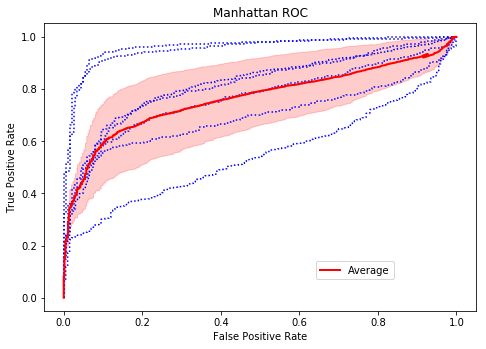

In [36]:
# store all fpr and tpr in np.array of np.arrays to calc an average ROC
fpr_list = []
tpr_list = []
eer_list = []
eer_std_list = []

fig = plt.figure()

for subject in subjects:
    real_user = df.loc[df.subject == subject]
    fake_user = df.loc[df.subject != subject]

    # We train our model using a genuine user's data
    training_data = real_user[:200].loc[:, 'H.period':'H.Return']
    
    # To test our model, we need both more data from the original user, and imposter user data
    genuine_user_data = real_user[200:].loc[:, 'H.period':'H.Return']
    imposter_user_data = fake_user[:].loc[:, 'H.period':'H.Return']
    
    # Let's check dimensions of our training and testing tuples are the same...just in case
    if training_data.shape != genuine_user_data.shape:
        sys.exit("training_data and genuine_user_data shapes don't match: {} | {}".format(training_data.shape, genuine_user_data.shape))
    elif imposter_user_data.shape[0] != genuine_user_data.shape[0]*100:
        sys.exit("imposter_user_data and genuine_user_data rows aren't 20000 and 200: {} | {}".format(imposter_user_data.shape[0], genuine_user_data.shape[0]))

    # Train
    mean_vector = training_data.mean().values # store mean vector in a numpy array to use with cityblock func below
    
    # Test - for each row (entry), compute cityblock distance between mean vector and test vector
    user_dists = []
    imposter_dists = []
    for i in range(genuine_user_data.shape[0]):
        dist = cityblock(genuine_user_data.iloc[i].values, mean_vector)
        user_dists.append(dist)

    for i in range(imposter_user_data.shape[0]):
        dist = cityblock(imposter_user_data.iloc[i].values, mean_vector)
        imposter_dists.append(dist)
        
    # Evaluate - compute equal error rates
    # Labels: 0 = user, 1 = imposter. We therefore need np arrays of 0s and 1s to same length as NSamples
    labels = [0]*len(user_dists) + [1]*len(imposter_dists)
    fpr, tpr, thresholds = roc_curve(labels, user_dists + imposter_dists) 

    # add roc curve of each model iteration to a pre-created figure
    # TODO add unique label to each axes we create here to suppress the annoying warning
    ax = fig.add_axes([0,0,1,1])
    ax.plot(fpr,tpr,'blue',ls=':')
    if subject == "s010":
        break

    # TPR = TP / (TP + FN) i.e. over total positives that shouldve been identified as true
    # FPR = FP / (FP + TN) i.e. over total negatives that shouldve been identified as true
    # TPR + FNR = 1
    # FPR + TNR = 1
    fnr = 1 - tpr
    
    # Equal error rate is where fnr = fpr (or minimum distance between them)      
    # So we calculate the absolute difference between fnr and fpr and find where that's minimised
    # Small differences are present depending on whether we do fnr[] or fpr[] as we aren't interpolating
    eer = fnr[np.nanargmin(np.absolute(fnr-fpr))]
    eer2 = fpr[np.nanargmin(np.absolute(fnr-fpr))]
    
    eer_list.append(eer)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
# https://docs.python.org/3/library/itertools.html#itertools.zip_longest
# https://stackoverflow.com/questions/52671807/python-multiple-lists-of-different-lengths-averages-and-standard-deviations
mean_fpr = np.nanmean(np.array(list(zip_longest(*fpr_list)),dtype=float),axis=1)
mean_tpr = np.nanmean(np.array(list(zip_longest(*tpr_list)),dtype=float),axis=1)

std_fpr = np.nanstd(np.array(list(zip_longest(*fpr_list)),dtype=float),axis=1) #,ddof=1
std_tpr = np.nanstd(np.array(list(zip_longest(*tpr_list)),dtype=float),axis=1) #,ddof=1

# for error bar propagation
up_tpr = mean_tpr + std_tpr #np.minimum(mean_tpr + std_tpr, 1)
low_tpr = mean_tpr - std_tpr

ax = fig.add_axes([0,0,1,1])
ax.set_title('Manhattan ROC')
ax.plot(mean_fpr,mean_tpr,'red',ls='-',lw=2,label='Average')
ax.fill_between(mean_fpr, low_tpr, up_tpr, color='red', alpha=0.2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
fig.legend(loc=[0.65,0.2])

# TODO could make table / output at end of , for each type of model, best eer, worst eer and mean eer    

In [35]:
# Compute average eer
print("Manhattan average equal error rate = {}".format(np.mean(eer_list)))
print("Manhattan corresponding standard deviation = {}".format(np.std(eer_list, ddof=0)))

Manhattan average equal error rate = 0.2789166666666667
Manhattan corresponding standard deviation = 0.11415246627014046


# Comments on Manhattan 

The fact that there's so much ROC variation implies we could probably tidy the data a bit to improve the model (seems like some users are more hard to predict than others).

## TODO GridSearchCV looks to be useful if we're using a model with many hyperparameters (to optimise our choices of them). 
But Manhattan doesn't have any hyperparameters - it's a very basic model utilising just the cityblock distance (which isn't really configurable by default, it has a definition). We could use different distance mesaures e.g. Euclidean, but I think GridSearchCV is really for if we were using e.g. an SVM

## TODO calculate a std dev for our model (to go alongside the eer)